# 04. Convolutional Neural Networks (CNN) — 讓電腦學會「看」

## 0. Notebook Header
- 作者：Paul Yang
- 目的：理解卷積 (Convolution) 與池化 (Pooling) 的數學原理，並使用 PyTorch 實作 CNN 解決 MNIST。
- 學會什麼：Conv2d, MaxPool2d, Stride, Padding, Feature Map 視覺化

## 1. 為什麼 MLP 不夠好？
在上一章，我們把 28x28 的圖片拉直成 784 的向量。這導致：
1. **空間資訊遺失**：模型不知道像素 A 和像素 B 其實在圖片上是相鄰的。
2.  **參數過多**：如果是大圖 (如 1000x1000)，全連接層的參數會爆炸。

**CNN 的解法**：用一個小的「視窗 (Kernel)」在圖片上滑動，尋找局部特徵 (如邊緣、角落)。

## 2. 手刻 NumPy 卷積函數 (The Math)

我們用三個層次來拆解 CNN 的核心原理：
1.  **Input 的差異**：為什麼 MLP 會把圖片「讀壞」？
2.  **卷積 (Convolution) 的數學**：濾鏡 (Filter) 到底是怎麼運作的？
3.  **手動推算**：我們用紙筆觀念來算一次。

---

### 1. Input 的差異：MLP vs. CNN 

#### MLP 的讀圖方式：暴力拉直 (Flatten)

想像你有一張 $28 \times 28$ 的手寫數字圖片（比如 MNIST）。
在上一章的 MLP 中，我們被迫做了一件事：`x = x.view(-1, 784)`。

* **動作**：這就像是你把一張拼圖拆散，把每一片拼圖排成「一條直線」。
* **數學後果**：
    * 像素 $(0, 0)$ 和 $(0, 1)$ 原本是鄰居（左右相鄰）。
    * 像素 $(0, 0)$ 和 $(1, 0)$ 原本也是鄰居（上下相鄰）。
    * **拉直後**：$(0, 0)$ 和 $(1, 0)$ 可能隔了 28 個位置！**原本「垂直相鄰」的空間關係被破壞了。**
* **結果**：模型失去了「形狀」的概念，它只能死記「第 500 個像素如果是黑色的，可能是 8」。如果把 8 往右移一格，特徵位置全變，MLP 就認不得了。

#### CNN 的讀圖方式：保留原樣 (Spatial Structure)

CNN 最偉大的地方在於：**它允許 Input 保持矩陣的樣子。**

* **MLP Input**: $(N, 784)$ —— 一條線。
* **CNN Input**: $(N, 1, 28, 28)$ —— 一疊圖片。
    * $N$: Batch Size (幾張圖)
    * $1$: Channel (色彩通道，黑白是 1，彩色 RGB 是 3)
    * $28, 28$: Height, Width (長寬)

**結論**：CNN 的起點，就是尊重圖片的「空間結構」。

---

### 2. 卷積 (Convolution) 的數學原理 

既然 Input 是矩陣，我們要怎麼從矩陣裡提取特徵？
答案是：**「濾鏡 (Filter / Kernel)」**。

想像你在玩手電筒照牆壁。
* **圖片 (Image)**：牆壁。
* **濾鏡 (Kernel)**：手電筒的光圈（例如 $3 \times 3$ 的小方框）。
* **卷積運算**：你拿著手電筒，從左上角開始，一格一格往右移、往下移（Sliding Window）。

#### 數學公式（點積和 Dot Product）

假設手電筒照到的圖片區域是 $X_{patch}$，濾鏡的權重是 $K$。
卷積的輸出 $Y$ 是一個數字：

$$Y = \sum (X_{patch} \cdot K) + b$$

這其實就是：**對應位置相乘，然後全部加起來**。

#### 舉個超簡單的例子（手算時間）

假設這是一張 **$3 \times 3$ 的圖片**（數字代表亮度）：
$$
\text{Image} = 
\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9
\end{bmatrix}
$$

假設這是一個 **$2 \times 2$ 的濾鏡**（用來偵測某種特徵）：
$$
\text{Kernel} = 
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

**Step 1：滑動到左上角 (蓋住 1, 2, 4, 5)**
我們把 Kernel 蓋在 Image 左上角的 $[1, 2, 4, 5]$ 上面。
進行「點積和」運算：

$$
(1 \times 1) + (2 \times 0) + (4 \times 0) + (5 \times 1)
$$
$$
= 1 + 0 + 0 + 5 = \mathbf{6}
$$

所以，輸出結果（Feature Map）的第一個像素就是 **6**。

**Step 2：往右移一格 (蓋住 2, 3, 5, 6)**
$$
(2 \times 1) + (3 \times 0) + (5 \times 0) + (6 \times 1)
$$
$$
= 2 + 0 + 0 + 6 = \mathbf{8}
$$

**結果 (Feature Map)**：
原本 $3 \times 3$ 的圖片，經過 $2 \times 2$ 的濾鏡掃描後，會變成一個 **$2 \times 2$ 的新矩陣**：
$$
\text{Output} = 
\begin{bmatrix}
6 & 8 \\
12 & 14
\end{bmatrix}
$$

---

### 3. 這代表什麼意義？ 

* **Kernel (濾鏡)**：就是神經網路要學習的「參數」。MLP 學的是權重 $W$，CNN 學的是濾鏡 $K$ 裡面的數字。
* **Feature Map (特徵圖)**：卷積出來的結果（那個 6, 8, 12, 14）。如果數字很大，代表「這裡有濾鏡想找的東西」（例如邊緣、圓弧、眼睛）。


In [6]:
import numpy as np

def convolve2d(image, kernel):
    """
    手刻 2D 卷積函數 (Basic Convolution)
    Args:
        image: 輸入圖片 (H, W)
        kernel: 濾鏡 (kH, kW)
    Returns:
        output: 卷積後的特徵圖 (Feature Map)
    """
    # 1. 取得形狀
    img_h, img_w = image.shape
    ker_h, ker_w = kernel.shape
    
    # 2. 計算輸出的尺寸 (Output Size)
    # 公式: Input - Kernel + 1
    # 舉例: 3 - 2 + 1 = 2
    out_h = img_h - ker_h + 1
    out_w = img_w - ker_w + 1
    
    # 3. 初始化輸出矩陣 (全 0)
    output = np.zeros((out_h, out_w))
    
    # 4. 滑動視窗 (Sliding Window)
    # 這是 CNN 最核心的迴圈！
    for y in range(out_h):
        for x in range(out_w):
            # A. 取出圖片上被濾鏡蓋住的區域 (切片 Slicing)
            # 範圍: 從 y 到 y+ker_h, 從 x 到 x+ker_w
            region = image[y : y+ker_h, x : x+ker_w]
            
            # B. 點積和運算 (Element-wise Multiply & Sum)
            # 這就是我們剛剛手算的: (1*1 + 2*0 + ...)
            output[y, x] = np.sum(region * kernel)
            
    return output

In [7]:
# 1. 定義我們剛剛手算的 3x3 圖片
# [[1, 2, 3],
#  [4, 5, 6],
#  [7, 8, 9]]
img_test = np.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
])

# 2. 定義 2x2 濾鏡
# [[1, 0],
#  [0, 1]]
kernel_test = np.array([
    [1, 0],
    [0, 1]
])

# 3. 執行卷積！
result = convolve2d(img_test, kernel_test)

print("原始圖片:\n", img_test)
print("\n濾鏡 (Kernel):\n", kernel_test)
print("\n卷積結果 (Feature Map):\n", result)

# 4. 自動檢查 (Assert)
# 看看是不是我們預期的 [[6, 8], [12, 14]]
expected = np.array([[6, 8], [12, 14]])

if np.array_equal(result, expected):
    print("\n恭喜！NumPy 實作與手算結果完全一致！")
else:
    print("\n咦？結果怪怪的，再檢查一下程式碼！")

原始圖片:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]

濾鏡 (Kernel):
 [[1 0]
 [0 1]]

卷積結果 (Feature Map):
 [[ 6.  8.]
 [12. 14.]]

恭喜！NumPy 實作與手算結果完全一致！


In [8]:
import numpy as np
import matplotlib.pyplot as plt

def convolve2d(image, kernel):
    """
    簡單的 2D 卷積實作 (stride=1, padding=0)
    """
    # 1. 取得圖片和濾鏡的尺寸
    img_h, img_w = image.shape
    ker_h, ker_w = kernel.shape
    
    # 2. 計算輸出 Feature Map 的尺寸
    # 公式：(Input - Kernel) + 1
    output_h = img_h - ker_h + 1
    output_w = img_w - ker_w + 1
    
    # 3. 初始化輸出的 Feature Map (全為 0)
    feature_map = np.zeros((output_h, output_w))
    
    # 4. 開始滑動視窗 (雙層迴圈)
    for y in range(output_h):
        for x in range(output_w):
            # 取出圖片中與 Kernel 重疊的區域 (Region of Interest)
            # 提示: 使用 slicing，例如 image[y:y+ker_h, x:x+ker_w]
            region = image[y:y+ker_h, x:x+ker_w]
            
            # 進行卷積運算：點積和 (Element-wise multiplication and sum)
            # 提示: np.sum(region * kernel)
            feature_map[y, x] = np.sum(region * kernel)
            
    return feature_map

In [9]:
# 1. 準備一張簡單的圖片 (6x6)
# 這裡畫一個十字架：中間是亮的(10)，背景是暗的(0)
image = np.array([
    [0, 0, 10, 10, 0, 0],
    [0, 0, 10, 10, 0, 0],
    [0, 0, 10, 10, 0, 0],
    [0, 0, 10, 10, 0, 0],
    [0, 0, 10, 10, 0, 0],
    [0, 0, 10, 10, 0, 0]
])

# 2. 定義一個「垂直邊緣檢測」濾鏡 (Vertical Filter)
# 左邊是負，右邊是正，中間是 0 -> 專門抓「由暗變亮」或「由亮變暗」的垂直線
vertical_filter = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
])

# 3. 定義一個「水平邊緣檢測」濾鏡 (Horizontal Filter)
# 上面是負，下面是正
horizontal_filter = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]
])

print("Image Shape:", image.shape)
print("Filter Shape:", vertical_filter.shape)

# 4. 執行卷積！
output_vertical = convolve2d(image, vertical_filter)
output_horizontal = convolve2d(image, horizontal_filter)

print("Output Shape:", output_vertical.shape) # 應該會變小 (4x4)

Image Shape: (6, 6)
Filter Shape: (3, 3)
Output Shape: (4, 4)


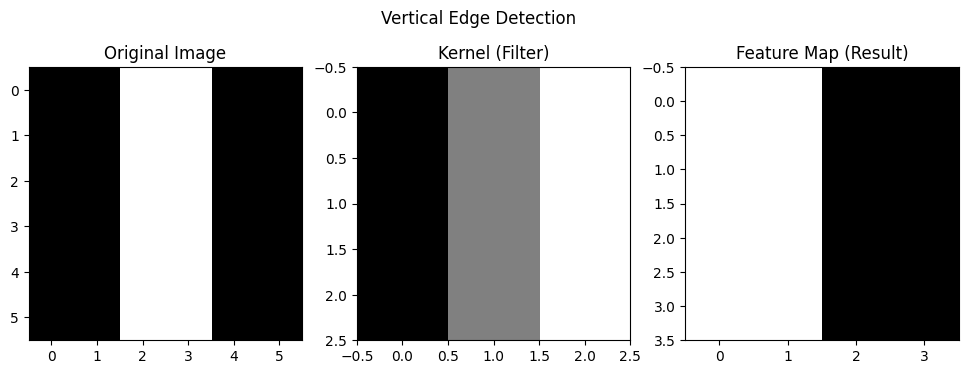

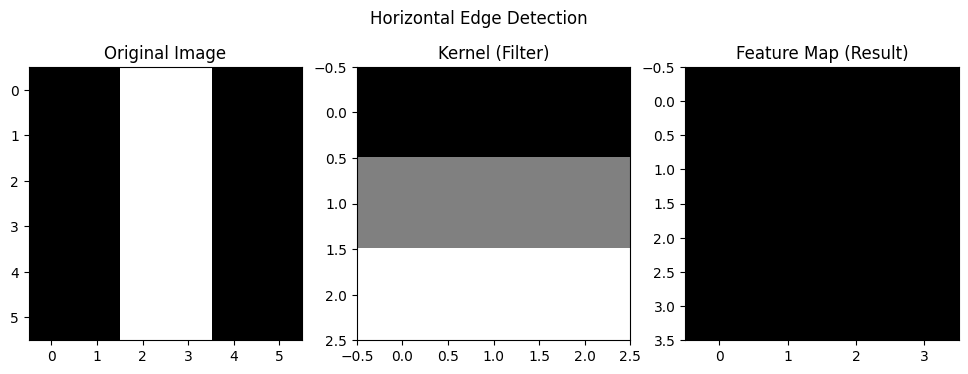

In [10]:
def plot_convolution(img, kernel, result, title):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # 畫原圖
    axes[0].imshow(img, cmap='gray')
    axes[0].set_title("Original Image")
    
    # 畫濾鏡
    axes[1].imshow(kernel, cmap='gray')
    axes[1].set_title("Kernel (Filter)")
    
    # 畫結果 (Feature Map)
    axes[2].imshow(result, cmap='gray')
    axes[2].set_title("Feature Map (Result)")
    
    plt.suptitle(title)
    plt.show()

# 看看垂直濾鏡的效果
plot_convolution(image, vertical_filter, output_vertical, "Vertical Edge Detection")

# 看看水平濾鏡的效果
plot_convolution(image, horizontal_filter, output_horizontal, "Horizontal Edge Detection")